## **Wage Inequality Among US Citizens in 1994 Based on Annual Income**

### Introduction

During much of the 1990s, the United States was subject to the largest economic expansion it had seen since the 1960s. A huge technological boom brought a 3% economic growth rate, two million new jobs, and a stable 2.1% inflation rate following a minor recession in 1990 (Nasar, 1994). With record low unemployment rates and the need for highly educated, fast-learning employees to keep up with other countries' technological advances, the United States saw an increase in income rates in 1994 compared to previous years (Nasar, 1994). Wage inequality was still prominent for many minorities in the workforce like women, immigrants, and people of colour, requiring the need for working long hours with lesser pay (Wilson, 2016). 

An analysis of the 1994 census data will allow us to predict whether a given person's income is greater or lesser than/equal to $50,000 based on factors like level of education, age, sex, race, native country, and hours worked per week. 

We will be using the `Adult` dataset taken from https://archive.ics.uci.edu/dataset/2/adult, which has extracted 32,560 entries from the 1994 US census which is a mandatory survey that collects data from all US citizens. Of the 32,560 rows, each observation represents a single person and their various attributes. There are 15 columns each signifying a different defining factor. The columns are:

 - `age`: age of individual (integer >0)
 - `workclass`: employment status (ex. self-employed, private, unemployed)
 - `fnlwgt`: final weight or the number of people this individual's entry represents (integer >0)
 - `education`: the highest level of education completed (ex. 12th grade, Bachelor's, Doctorate)
 - `education-num`: the highest level of education completed in numerical form (integer >0)
 - `marital-status`: marital status (ex. married, single)
 - `occupation`: general type of occupation held (ex. sales, services, etc.)
 - `relationship`: primary relationship to others (ex. wife, husband, relative)
 - `race`: racial identity (ex. white, black, asian)
 - `sex`: biological sex (ex. male, female)
 - `capital-gain`: money earned on investments (integer >0)
 - `capital-loss`: money lost on investments (integer >0)
 - `hours-per-week`: hours at work each week
 - `native-country`: country of origin (ex. United States, India, Cuba)
 - `income`: annual income in USD (integer <=50k, >50k)

### Preliminary Data Analysis

In [1]:
# Loading libraries
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Reading downloaded csv file
adult <- read_csv("data/adult.csv")

# Adding column names
colnames(adult) <- c('age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                     'marital_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')
slice(adult, 1:4)

Rows: 32560 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Many of the predictors are categorical so we need to convert them into numerical values
adult_numerical <- adult |>
    select(workclass, education, marital_status, occupation, relationship, race, sex, native_country) |>
    mutate(across(workclass:native_country, as.factor)) |>
    sapply(unclass) 
adult_final <- adult |>
    select(age, fnlwgt, education_num, capital_gain, capital_loss, hours_per_week, income)
adult_final <- cbind(adult_final, adult_numerical) |>
    mutate(income = as_factor(income))

# Getting the training data
set.seed(3456) 

# Randomly take 75% of the data in the training set. 
adult_split <- initial_split(adult_final, prop = 0.75, strata = income)  
adult_train <- training(adult_split)   
adult_test <- testing(adult_split)

In [4]:
# Beginning data analysis:
# Data summary
# We will take the mean of our numerical predictors and the mode of our categorical predictors

analysis_mean <- adult_train |>
    select(age, fnlwgt, capital_gain, capital_loss, hours_per_week) |>
    map_df(mean, na.rm = TRUE)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

analysis_mode <- adult |>
    select(workclass, education, marital_status, occupation, relationship, race, sex, native_country) |>
    map_df(getmode)

# Mean value of our numerical predictors
analysis_mean
# Most frequent value of our categorical predictors 
analysis_mode

age,fnlwgt,capital_gain,capital_loss,hours_per_week
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
38.60363,189183.4,1136.137,88.29805,40.44252


workclass,education,marital_status,occupation,relationship,race,sex,native_country
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States


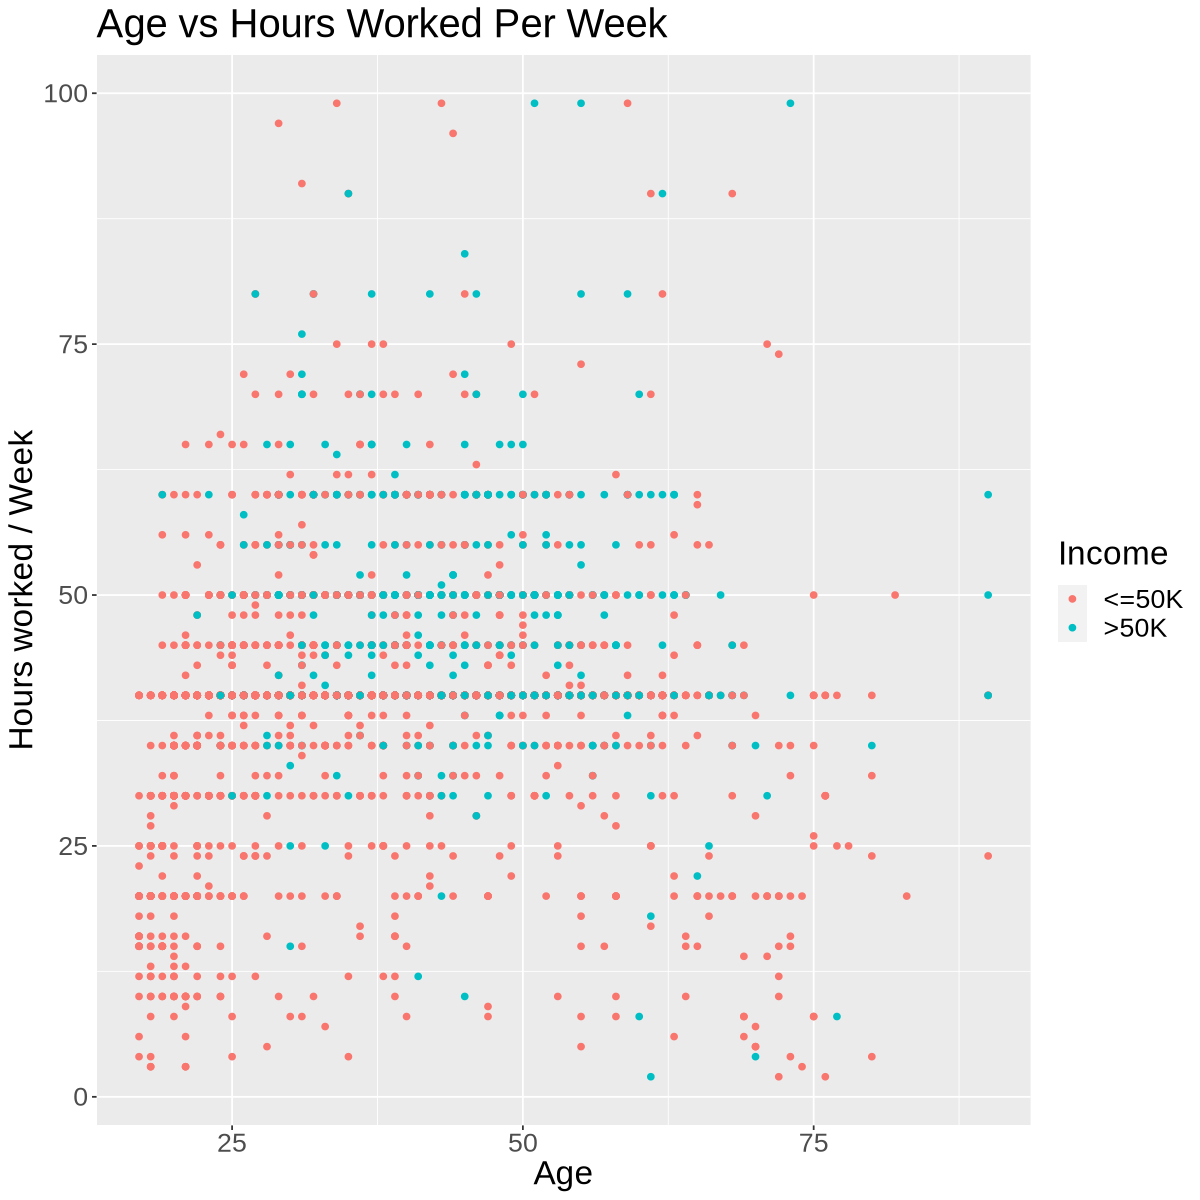

In [6]:
# Data visualization 
# Scatter plot of Age vs Hours Per Week
options(repr.plot.width=10, repr.plot.height=10)

# Currently there is too much data so we want to take a small sample to improve the visualization
filtered_adult <- adult_train |>
    sample_n(2500) 

# Generate plot of Age vs Hours with Coloured Income
age_vs_hrs <- filtered_adult |>
    ggplot(aes(x = age, y = hours_per_week)) +
    geom_point(aes(colour = income)) +
    labs(x = "Age", y = "Hours worked / Week", colour = "Income") +
    ggtitle("Age vs Hours Worked Per Week") +
    theme(text = element_text(size = 20))

age_vs_hrs

### Methods

#### *Chosen Variables*

Our question is a classification problem so we want to use the K nearest neighbours model in tidymodels. Since we converted all columns to numerical we can use any column as a predictor, but we are wanting to limit our predictors to only the most relevant. The predictive variables we plan to use includes:
1. `age`: Ex. Are people of the same age range (usually in a similar stage in their careers) making more or less based on their race, sex, or native country?
2. `education-num`: Ex. Are certain groups receiving longer years of education and how is this linked to their income of someone with the same years of education but a different race, sex, or native country?
3. `race`: primary comparative measure for wage inequality
4. `sex`: primary comparative measure for wage inequality
5. `hours-per-week`: Ex. How many hours a week does each race, sex, or non-native US resident work compared to other groups and how does working more relate to income received?
6. `native-country`: primary comparative measure for wage inequality
7. `income`: main data to answer predictive question

This is subject to change as we analyse the relevance of each variable to the likelihood of indicating income above or below/equal to 50,000 dollars. 

#### *Visualization Examples*
- `geom_point`: Compare age to home many hours worked per week and colour for income to see if younger people have a higher or lower income compared to their older counterparts and if that is connected to working longer hours. (see graph above)
- `geom_bar`: Compare different races to their level of years of education and use a double bar set-up to see within each race group who makes above or below/equal to 50,000 dollars.
- `geom_histogram`: Compare different age groups to their years of education to see if younger people have more or less education.


### Expected Outcomes & Significance  

#### *Expected Findings*
- More younger people have an annual income greater than 50,000 dollars due to results also showing them having longer years of formal education.
- More non-white, female, immigrants are likely to have an annual income less than 50,000 compared to white, male, native US residents.
- More non-white, female, immigrants work longer hours than white, male, native US residents despite having a lower income.
- White, male, native US residents are likely to have longer years of formal education leading to their higher annual income.

#### *Impact of Findings*
The results of the suggested findings can be compared to modern day statistics to determine if the annual income for different race, sex, age, and native groups has changed. Modern findings may suggest a decrease in wage inequality between race and sex groups, allowing for people to identify what changes were made to lead to this result. If modern stats show immigrants making an annual income more comparable to a native US resident than in 1994, the government can use it as a way of attracting migrants to the country. If in 2024, data shows younger generations having even more years of formal education compared to older generations, the government can advertise a rise in national education levels. 

#### *Future Questions*
- Is formal education an important way to increase annual income in 2024 compared to 30 years ago?
- Has the wage gap between different race, sex, and resident groups in the United States changed in the last 30 years?
- Are US immigrants likely to receive financial support comparable to native US residents in 2024?